[![DOI](https://zenodo.org/badge/940091341.svg)](https://doi.org/10.5281/zenodo.14939868) <a href="https://www.globh2e.org.au/"><img src="https://img.shields.io/badge/ARC:Funding%20number-IC200100023-blue.svg"/></a>

# **Pathways to global hydrogen production within planetary boundaries**
**<div style="text-align: left; font-size: 19px;"> Interaction parameters**</div>

<div style="text-align: left; font-size: 16px;">Michaël Lejeune<sup>a,b</sup>, Sami Kara<sup>a,b</sup>, Michael Zwicky Hauschild<sup>c,d</sup>, Sareh Sharabifarahni<sup>a</sup>, Rahman Daiyan<sup>b,e</sup></div><br>

<div style="text-align: left; font-size: 13px;"><sup>a</sup>Sustainability in Manufacturing and Life Cycle Engineering Research Group, School of Mechanical and Manufacturing Engineering, the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>b</sup>Australian Research Council Training Centre for the Global Hydrogen Economy (GlobH2e), the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>c</sup>Centre for Absolute Sustainability, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>d</sup>Division for Quantitative Sustainability Assessment (QSA), Department of Environmental and Resource Engineering, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>e</sup>School of Minerals and Energy Engineering, The University of New South Wales, Sydney 2052, Australia</div><br>

<div style="text-align: left; font-size: 13px;"> Code developer and maintainer:<a href="mailto:m.lejeune@unsw.edu.au"> Michaël Lejeune</div></a><br>

# **0. Initialisation**

In [114]:
using LinearAlgebra, Statistics, InvertedIndices, SparseArrays
using JLD2
include("Utils/1_00_utils.jl")
;


Setting rcParams


<div style="background-color:rgb(204, 237, 255); padding: 10px; border-radius: 5px;">
    <p style="color:rgb(0, 133, 204); font-weight: bold;">
        Note on mathematical array notations and format</p>
<p style="color:rgb(0, 133, 204); font-weight: bold;">

For Matrices, we use bold capital letters, e.g. $\boldsymbol{A}$, and for vectors, we use bold lowercase letters, e.g. $\boldsymbol{a}$. The elements of a matrix are denoted by $A_{ij}$, where $i$ is the row index and $j$ is the column index. For vectors, the elements are denoted by $a_i$, where $i$ is the index of the vector element.

Note that all coefficients (i.e., $A_{ij}$ and $a_i$) are normalised to assess boundaries and interactions on the same scale.
</p></div>

$$
x=\frac{X-X_0}{X_{PB}-X_0}
$$

hence
$$
s=\frac{\Delta y}{\Delta x}
$$

A change in un-normalized control variable ΔX causes a change in another un-normalized control variable ΔY (but XPB and YPB are fixed):
$$
s=\frac{\Delta Y}{\Delta X} \frac{X_{PB}-X_0}{Y_{PB}-Y_0}
$$
A change in un-normalized control variable ΔX causes a change in the boundary value of another planetary boundary from YPB to Y′PB (but XPB and Y are fixed):

$$
s=\left(\frac{Y-Y_0}{Y_{PB}^{\prime}-Y_0}-\frac{Y-Y_0}{Y_{PB}-Y_0}\right) \frac{X_{PB}-X_0}{\Delta X}
$$
We expect that this type of interaction would also change the zone of uncertainty, but we do not model this effect here.

Changes in control variables and boundary values are as for equation (4), but evidence of the change in the originating control variable is available in normalized units Δx:

$$
s=\left(\frac{Y-Y_0}{Y_{PB}^{\prime}-Y_0}-\frac{Y-Y_0}{Y_{PB}-Y_0}\right) \frac{1}{\Delta x}
$$

In [131]:
ᶜᶜ = 1 # Climate Change
ᴮᴵˡ = 2 # BI Land
ᴮᴵᶠ = 3 # BI Freshwater
ᴮᴵᴼ = 4  # BI Ocean
ˡˢᶜ = 5 # Land System Change
ᴮᶜᶠ = 6 # Biogeochemical Flows
ᴼᵃ = 7 # Ocean Acidification
ᶠʷᵘ = 8 # Freshwater Use
ᵃᵃˡ = 9 # Aerosol Loading
ˢᵒᵈ = 10 # Strat. Ozone Depletion

S =[ᶜᶜ ᴮᴵˡ ᴮᴵᶠ ᴮᴵᴼ ˡˢᶜ ᴮᶜᶠ ᴼᵃ ᶠʷᵘ ᵃᵃˡ ˢᵒᵈ] # Set of all planetary boundaries

𝐈=I(10) # Identity matrix
𝐁  = zeros(length(s),length(s))
𝐏 = zeros(length(s),length(s))
𝐑 = zeros(length(s),length(s));


In [116]:
𝐁a = [
    1.0     0.15    0.38    0.22    0.10    0.19    -0.07   -0.08   0       -0.06   # Climate Change
    0.22    1       0       0       0       0       0.08    0       0       0       # BI Land
    0.17    0       1       0       0       0       0.04    0       0       0       # BI Freshwater
    0.15    0       0       1       0       0       0.06    0       0       0       # BI Ocean
    0.12    0.8     0.08    0       1       0       0.16    -0.11   0       0       # Land System Change
    0.04    0.02    1       0.05    0       1       -0.03   0       0.10    0.01    # Biogeochemical Flows
    0.10    0       0       1       0       0       1       0       0       0       # Ocean Acidification
    0       0       1       0       0       0       0       1       0       0       # Freshwater Use
    -0.56   0       0       0       0       0       0       0       1       0       # Aerosol Loading
    -0.11   0       0       0       0       0       0       0       0       1       # Strat. Ozone Deplet.
    ]-𝐈|>sparse


10×10 SparseMatrixCSC{Float64, Int64} with 31 stored entries:
   ⋅    0.15  0.38  0.22  0.1  0.19  -0.07  -0.08   ⋅   -0.06
  0.22   ⋅     ⋅     ⋅     ⋅    ⋅     0.08    ⋅     ⋅     ⋅ 
  0.17   ⋅     ⋅     ⋅     ⋅    ⋅     0.04    ⋅     ⋅     ⋅ 
  0.15   ⋅     ⋅     ⋅     ⋅    ⋅     0.06    ⋅     ⋅     ⋅ 
  0.12  0.8   0.08   ⋅     ⋅    ⋅     0.16  -0.11   ⋅     ⋅ 
  0.04  0.02  1.0   0.05   ⋅    ⋅    -0.03    ⋅    0.1   0.01
  0.1    ⋅     ⋅    1.0    ⋅    ⋅      ⋅      ⋅     ⋅     ⋅ 
   ⋅     ⋅    1.0    ⋅     ⋅    ⋅      ⋅      ⋅     ⋅     ⋅ 
 -0.56   ⋅     ⋅     ⋅     ⋅    ⋅      ⋅      ⋅     ⋅     ⋅ 
 -0.11   ⋅     ⋅     ⋅     ⋅    ⋅      ⋅      ⋅     ⋅     ⋅ 

In [130]:
sparse(round.(𝐁,digits=2))


10×10 SparseMatrixCSC{Float64, Int64} with 30 stored entries:
   ⋅    0.15  0.38  0.22  0.1   0.07  -0.07  -0.08   ⋅    -0.05
  0.22   ⋅     ⋅     ⋅     ⋅     ⋅     0.08    ⋅     ⋅      ⋅ 
  0.18   ⋅     ⋅     ⋅     ⋅     ⋅     0.04    ⋅     ⋅      ⋅ 
  0.15   ⋅     ⋅     ⋅    0.02   ⋅     0.15    ⋅     ⋅      ⋅ 
  0.13  0.8   0.08   ⋅     ⋅     ⋅     0.16   0.23   ⋅      ⋅ 
  0.04  0.02   ⋅     ⋅     ⋅     ⋅    -0.03    ⋅    0.08   0.01
 -0.1    ⋅     ⋅    1.0    ⋅     ⋅      ⋅      ⋅     ⋅      ⋅ 
   ⋅     ⋅    1.0    ⋅     ⋅     ⋅      ⋅      ⋅     ⋅      ⋅ 
 -0.56   ⋅     ⋅     ⋅     ⋅     ⋅      ⋅      ⋅     ⋅      ⋅ 
 -0.11   ⋅     ⋅     ⋅     ⋅     ⋅      ⋅      ⋅     ⋅      ⋅ 

# **1. Biophysical interactions**

## **1.1. Climate change**

In [118]:
# --- Climate change → Biosphere Integrity (land) ---
Δxᶜᶜ⁻ᴮᴵˡ = 2.0    # Normalised current climate change control variable :contentReference[oaicite:0]{index=0} :contentReference[oaicite:0]{index=0}
Δyᶜᶜ⁻ᴮᴵˡ = 0.3   # Central estimate of current loss of biosphere integrity due to CC (20% of 1.5) :contentReference[oaicite:1]{index=1} :contentReference[oaicite:1]{index=1}
sᶜᶜ⁻ᴮᴵˡ = Δyᶜᶜ⁻ᴮᴵˡ / Δxᶜᶜ⁻ᴮᴵˡ
𝐁[ᶜᶜ, ᴮᴵˡ] = sᶜᶜ⁻ᴮᴵˡ

# --- Climate change → Biosphere Integrity (freshwater) ---
Δxᶜᶜ⁻ᴮᴵᶠ = 2.0    # Normalised current climate change control variable :contentReference[oaicite:2]{index=2} :contentReference[oaicite:2]{index=2}
Δyᶜᶜ⁻ᴮᴵᶠ = 2.3/3  # Cyanobacterial ratio–based estimate :contentReference[oaicite:3]{index=3} :contentReference[oaicite:3]{index=3}
sᶜᶜ⁻ᴮᴵᶠ = Δyᶜᶜ⁻ᴮᴵᶠ / Δxᶜᶜ⁻ᴮᴵᶠ
𝐁[ᶜᶜ, ᴮᴵᶠ] = sᶜᶜ⁻ᴮᴵᶠ

# --- Climate change → Biosphere Integrity (ocean) ---
Δxᶜᶜ⁻ᴮᴵᴼ = 2.0    # Normalised current climate change control variable :contentReference[oaicite:4]{index=4} :contentReference[oaicite:4]{index=4}
Δyᶜᶜ⁻ᴮᴵᴼ = 0.22   # Mean of fisheries, yield and coral estimates :contentReference[oaicite:5]{index=5} :contentReference[oaicite:5]{index=5}
sᶜᶜ⁻ᴮᴵᴼ = Δyᶜᶜ⁻ᴮᴵᴼ / Δxᶜᶜ⁻ᴮᴵᴼ
𝐁[ᶜᶜ, ᴮᴵᴼ] = sᶜᶜ⁻ᴮᴵᴼ

# --- Climate change → Biosphere Integrity (ocean) (corrected) ---
sᶜᶜ⁻ᴮᴵᴼ = 0.22   # Biophysical interaction strength from Supplementary Table 2 :contentReference[oaicite:0]{index=0}
Δxᶜᶜ⁻ᴮᴵᴼ = 2.0   # Normalised current climate‐change control variable :contentReference[oaicite:1]{index=1}
Δyᶜᶜ⁻ᴮᴵᴼ = sᶜᶜ⁻ᴮᴵᴼ * Δxᶜᶜ⁻ᴮᴵᴼ  # Implied change in BI(ocean) for Δx = 2.0
𝐁[ᶜᶜ, ᴮᴵᴼ] = sᶜᶜ⁻ᴮᴵᴼ

# --- Climate change → Land system change (added) ---
Δxᶜᶜ⁻ˡˢᶜ = 2.0
Δyᶜᶜ⁻ˡˢᶜ = 0.20
sᶜᶜ⁻ˡˢᶜ = Δyᶜᶜ⁻ˡˢᶜ / Δxᶜᶜ⁻ˡˢᶜ
𝐁[ᶜᶜ, ˡˢᶜ] = sᶜᶜ⁻ˡˢᶜ


# --- Climate change → Freshwater Use ---
Δxᶜᶜ⁻ᶠʷᵘ = 2.0         # Normalised current climate change control variable :contentReference[oaicite:6]{index=6} :contentReference[oaicite:6]{index=6}
Δyᶜᶜ⁻ᶠʷᵘ = -0.16#1362.5/4000 # Increase in global runoff :contentReference[oaicite:7]{index=7} :contentReference[oaicite:7]{index=7}
sᶜᶜ⁻ᶠʷᵘ = Δyᶜᶜ⁻ᶠʷᵘ / Δxᶜᶜ⁻ᶠʷᵘ
𝐁[ᶜᶜ, ᶠʷᵘ] = sᶜᶜ⁻ᶠʷᵘ

# --- Climate change → Ocean Acidification ---
Δxᶜᶜ⁻ᴼᵃ = 2.0    # Normalised current climate change control variable :contentReference[oaicite:8]{index=8} :contentReference[oaicite:8]{index=8}
Δyᶜᶜ⁻ᴼᵃ = -0.14  # Buffering of aragonite saturation state by warming (15%) :contentReference[oaicite:9]{index=9} :contentReference[oaicite:9]{index=9}
sᶜᶜ⁻ᴼᵃ = Δyᶜᶜ⁻ᴼᵃ / Δxᶜᶜ⁻ᴼᵃ
𝐁[ᶜᶜ, ᴼᵃ] = sᶜᶜ⁻ᴼᵃ

# --- Climate change → Stratospheric Ozone Depletion ---
Δxᶜᶜ⁻ˢᵒᵈ = (369 - 280) / (350 - 280)  # CO₂ concentration normalisation :contentReference[oaicite:10]{index=10} :contentReference[oaicite:10]{index=10}
Δyᶜᶜ⁻ˢᵒᵈ = -0.06              # Ozone change from stratospheric cooling :contentReference[oaicite:11]{index=11} :contentReference[oaicite:11]{index=11}
sᶜᶜ⁻ˢᵒᵈ = Δyᶜᶜ⁻ˢᵒᵈ / Δxᶜᶜ⁻ˢᵒᵈ
𝐁[ᶜᶜ, ˢᵒᵈ] = sᶜᶜ⁻ˢᵒᵈ

# --- Climate change → Biogeochemical Flows ---
Δxᶜᶜ⁻ᴮᶜᶠ = 2.0       # Normalised current climate change control variable :contentReference[oaicite:12]{index=12} :contentReference[oaicite:12]{index=12}
Δyᶜᶜ⁻ᴮᶜᶠ = 0.88/6.2 # Phosphorus runoff increase :contentReference[oaicite:13]{index=13} :contentReference[oaicite:13]{index=13}
sᶜᶜ⁻ᴮᶜᶠ = Δyᶜᶜ⁻ᴮᶜᶠ / Δxᶜᶜ⁻ᴮᶜᶠ
𝐁[ᶜᶜ, ᴮᶜᶠ] = sᶜᶜ⁻ᴮᶜᶠ



0.07096774193548387

## **1.2 Biosphere integrity land**

In [120]:
# --- Biosphere integrity (land) → Climate change ---
Δxᴮᴵˡ⁻ᶜᶜ = 1.0    # Normalised loss of land biosphere integrity from 100% to 90% (ΔX = –10%) :contentReference[oaicite:0]{index=0}
Δyᴮᴵˡ⁻ᶜᶜ = 0.22   # Normalised change in climate boundary: ΔY = (2/3)*23.4 ppm = 15.3 ppm, over 70 ppm range → 15.3/70 ≈ 0.22 :contentReference[oaicite:1]{index=1}
sᴮᴵˡ⁻ᶜᶜ  = Δyᴮᴵˡ⁻ᶜᶜ / Δxᴮᴵˡ⁻ᶜᶜ
𝐁[ᴮᴵˡ, ᶜᶜ] = sᴮᴵˡ⁻ᶜᶜ

# --- Biosphere integrity (land) → Ocean acidity (Ocean Acidification) ---
Δxᴮᴵˡ⁻ᴼᵃ = 1.0    # Same normalised Δx = 1.0 for 10% drop in land biosphere integrity :contentReference[oaicite:2]{index=2}
Δyᴮᴵˡ⁻ᴼᵃ = 0.08   # Extra acidification: 0.8*(16.7/155) ≈ 0.08 :contentReference[oaicite:3]{index=3}
sᴮᴵˡ⁻ᴼᵃ  = Δyᴮᴵˡ⁻ᴼᵃ / Δxᴮᴵˡ⁻ᴼᵃ
𝐁[ᴮᴵˡ, ᴼᵃ] = sᴮᴵˡ⁻ᴼᵃ


0.08

## **1.3 Biosphere integrity Freshwater**

In [121]:
# --- Biosphere integrity (freshwater) → Ocean Acidification ---
Δxᴮᴵᶠ⁻ᴼᵃ = 1.2      # Δx = 2.3 * 53% = 1.2  :contentReference[oaicite:0]{index=0} :contentReference[oaicite:0]{index=0}
Δyᴮᴵᶠ⁻ᴼᵃ = 0.042    # Δy = 2.0 * (1 PgC·yr⁻¹ × 20% / 9.5 PgC·yr⁻¹) = 0.042  :contentReference[oaicite:1]{index=1} :contentReference[oaicite:1]{index=1}
sᴮᴵᶠ⁻ᴼᵃ  = Δyᴮᴵᶠ⁻ᴼᵃ / Δxᴮᴵᶠ⁻ᴼᵃ
𝐁[ᴮᴵᶠ, ᴼᵃ] = sᴮᴵᶠ⁻ᴼᵃ

# --- Biosphere integrity (freshwater) → Climate Change ---
Δxᴮᴵᶠ⁻ᶜᶜ = 1.2      # Δx = 2.3 * 53% = 1.2  :contentReference[oaicite:2]{index=2} :contentReference[oaicite:2]{index=2}
Δyᴮᴵᶠ⁻ᶜᶜ = 0.21     # Δy = 2.0 * 11% = 0.21  :contentReference[oaicite:3]{index=3} :contentReference[oaicite:3]{index=3}
sᴮᴵᶠ⁻ᶜᶜ   = Δyᴮᴵᶠ⁻ᶜᶜ / Δxᴮᴵᶠ⁻ᶜᶜ
𝐁[ᴮᴵᶠ, ᶜᶜ] = sᴮᴵᶠ⁻ᶜᶜ


0.175

## **1.4 Biosphere integrity Ocean**

In [122]:
# --- Biosphere integrity (ocean) → Climate Change ---
Δxᴮᴵᴼ⁻ᶜᶜ = 1.0    # Normalised loss from pre-industrial to the ocean-biosphere boundary (Δx = 1) :contentReference[oaicite:0]{index=0}
Δyᴮᴵᴼ⁻ᶜᶜ = 0.15   # Combined acidification- (0.09) and temperature-mediated (0.06) feedbacks on atmospheric CO₂ :contentReference[oaicite:1]{index=1}
sᴮᴵᴼ⁻ᶜᶜ   = Δyᴮᴵᴼ⁻ᶜᶜ / Δxᴮᴵᴼ⁻ᶜᶜ
𝐁[ᴮᴵᴼ, ᶜᶜ] = sᴮᴵᴼ⁻ᶜᶜ

# --- Biosphere integrity (ocean) → Land System Change ---
Δxᴮᴵᴼ⁻ˡˢᴄ = 1.0    # Hypothetical full collapse of marine biosphere integrity (Δx = 1) :contentReference[oaicite:2]{index=2}
Δyᴮᴵᴼ⁻ˡˢᴄ = 0.02   # Increased land clearing to replace lost fish protein (80%×6.7%×1.5/2×0.5) :contentReference[oaicite:3]{index=3}
sᴮᴵᴼ⁻ˡˢᴄ  = Δyᴮᴵᴼ⁻ˡˢᴄ / Δxᴮᴵᴼ⁻ˡˢᴄ
𝐁[ᴮᴵᴼ, ˡˢᶜ] = sᴮᴵᴼ⁻ˡˢᴄ

# --- Biosphere integrity (ocean) → Ocean Acidification ---
Δxᴮᴵᴼ⁻ᴼᵃ = 1.0    # Same Δx = 1 for full loss of ocean biosphere integrity :contentReference[oaicite:4]{index=4}
Δyᴮᴵᴼ⁻ᴼᵃ = 0.15   # Feedback via weakening of the marine biological pump (same 0.15 as ocean→CC) :contentReference[oaicite:5]{index=5}
sᴮᴵᴼ⁻ᴼᵃ  = Δyᴮᴵᴼ⁻ᴼᵃ / Δxᴮᴵᴼ⁻ᴼᵃ
𝐁[ᴮᴵᴼ, ᴼᵃ] = sᴮᴵᴼ⁻ᴼᵃ


0.15

## **1.5 Land System Change**

In [123]:
# --- Land system change → Climate change ---
Δxˡˢᶜ⁻ᶜᶜ = 1.5                  # Combined biophysical Δx from emissions and albedo effects :contentReference[oaicite:0]{index=0} :contentReference[oaicite:0]{index=0}
Δyˡˢᶜ⁻ᶜᶜ = 0.59 - 0.40          # Emissions‐driven increase (0.59) minus albedo‐driven cooling (0.40) :contentReference[oaicite:1]{index=1}
sˡˢᶜ⁻ᶜᶜ = Δyˡˢᶜ⁻ᶜᶜ / Δxˡˢᶜ⁻ᶜᶜ
𝐁[ˡˢᶜ, ᶜᶜ] = sˡˢᶜ⁻ᶜᶜ

# --- Land system change → Biosphere integrity (land) ---
Δxˡˢᶜ⁻ᴮᴵˡ = 1.5                # Normalised change in land‐use control variable for biosphere integrity (land) :contentReference[oaicite:1]{index=1} :contentReference[oaicite:2]{index=2}
Δyˡˢᶜ⁻ᴮᴵˡ = 1.2                # Species‐extinction metric ΔY from land system change :contentReference[oaicite:3]{index=3}
sˡˢᶜ⁻ᴮᴵˡ = Δyˡˢᶜ⁻ᴮᴵˡ / Δxˡˢᶜ⁻ᴮᴵˡ
𝐁[ˡˢᶜ, ᴮᴵˡ] = sˡˢᶜ⁻ᴮᴵˡ

# --- Land system change → Biosphere integrity (freshwater) ---
Δxˡˢᶜ⁻ᴮᴵᶠ = 2.4                # Normalised land‐use Δx for freshwater‐biosphere impacts :contentReference[oaicite:2]{index=2} :contentReference[oaicite:4]{index=4}
Δyˡˢᶜ⁻ᴮᴵᶠ = 1.0/5              # Proportional ΔY in freshwater biosphere integrity (normalized) :contentReference[oaicite:5]{index=5}
sˡˢᶜ⁻ᴮᴵᶠ = Δyˡˢᶜ⁻ᴮᴵᶠ / Δxˡˢᶜ⁻ᴮᴵᶠ
𝐁[ˡˢᶜ, ᴮᴵᶠ] = sˡˢᶜ⁻ᴮᴵᶠ

# --- Land system change → Ocean Acidification ---
Δxˡˢᶜ⁻ᴼᵃ = 1.5                # Normalised land‐use Δx for OA feedback via nutrient runoff :contentReference[oaicite:3]{index=3} :contentReference[oaicite:6]{index=6}
Δyˡˢᶜ⁻ᴼᵃ = 0.24               # ΔY in ocean acidification from enhanced nutrient inputs :contentReference[oaicite:7]{index=7}
sˡˢᶜ⁻ᴼᵃ = Δyˡˢᶜ⁻ᴼᵃ / Δxˡˢᶜ⁻ᴼᵃ
𝐁[ˡˢᶜ, ᴼᵃ] = sˡˢᶜ⁻ᴼᵃ

# --- Land system change → Freshwater Use ---
Δxˡˢᶜ⁻ᶠʷᵘ = 1.5                # Normalised land‐use Δx for freshwater‐use effects :contentReference[oaicite:4]{index=4} :contentReference[oaicite:8]{index=8}
Δyˡˢᶜ⁻ᶠʷᵘ = 1362.5/4000       # ΔY from increased runoff normalized to freshwater boundary (km³ yr⁻¹) :contentReference[oaicite:9]{index=9}
sˡˢᶜ⁻ᶠʷᵘ = Δyˡˢᶜ⁻ᶠʷᵘ / Δxˡˢᶜ⁻ᶠʷᵘ
𝐁[ˡˢᶜ, ᶠʷᵘ] = sˡˢᶜ⁻ᶠʷᵘ


0.22708333333333333

## **1.6 Biogeochemical Flows**

In [124]:
# --- Biogeochemical flows → Climate Change ---
Δxᴮᶜᶠ⁻ᶜᶜ = 2.3    # Current normalised biogeochemical flows control variable (P+N cycles) :contentReference[oaicite:0]{index=0}
Δyᴮᶜᶠ⁻ᶜᶜ = 0.086  # GHG emissions from nutrient application (0.41 PgC/yr) as fraction of annual emissions (9.5 PgC/yr) → 0.41/9.5*2 :contentReference[oaicite:1]{index=1}
sᴮᶜᶠ⁻ᶜᶜ = Δyᴮᶜᶠ⁻ᶜᶜ / Δxᴮᶜᶠ⁻ᶜᶜ
𝐁[ᴮᶜᶠ, ᶜᶜ] = sᴮᶜᶠ⁻ᶜᶜ

# --- Biogeochemical flows → Biosphere Integrity (land) ---
Δxᴮᶜᶠ⁻ᴮᴵˡ = 2.3    # Current normalised nutrient application control variable :contentReference[oaicite:2]{index=2}
Δyᴮᶜᶠ⁻ᴮᴵˡ = 0.045  # Land MSA loss: 3% decrease of 1.5 normalised units → 0.03*1.5 :contentReference[oaicite:3]{index=3}
sᴮᶜᶠ⁻ᴮᴵˡ = Δyᴮᶜᶠ⁻ᴮᴵˡ / Δxᴮᶜᶠ⁻ᴮᴵˡ
𝐁[ᴮᶜᶠ, ᴮᴵˡ] = sᴮᶜᶠ⁻ᴮᴵˡ

# --- Biogeochemical flows → Ocean Acidification ---
Δxᴮᶜᶠ⁻ᴼᵃ = 2.3       # Current normalised nutrient application control variable :contentReference[oaicite:4]{index=4}
Δyᴮᶜᶠ⁻ᴼᵃ = -0.074   # Buffering of acidification by fertilisation uptake: 0.8*(–0.88/9.5) :contentReference[oaicite:5]{index=5}
sᴮᶜᶠ⁻ᴼᵃ   = Δyᴮᶜᶠ⁻ᴼᵃ / Δxᴮᶜᶠ⁻ᴼᵃ
𝐁[ᴮᶜᶠ, ᴼᵃ] = sᴮᶜᶠ⁻ᴼᵃ

# --- Biogeochemical flows → Aerosol Loading ---
Δxᴮᶜᶠ⁻ᵃᵃˡ = 2.3     # Current normalised nutrient application control variable :contentReference[oaicite:6]{index=6}
Δyᴮᶜᶠ⁻ᵃᵃˡ = 0.18    # 15% of 1.6 normalised aerosol loading (NH₃→PM formation) :contentReference[oaicite:7]{index=7}
sᴮᶜᶠ⁻ᵃᵃˡ = Δyᴮᶜᶠ⁻ᵃᵃˡ / Δxᴮᶜᶠ⁻ᵃᵃˡ
𝐁[ᴮᶜᶠ, ᵃᵃˡ] = sᴮᶜᶠ⁻ᵃᵃˡ

# --- Biogeochemical flows → Strat. Ozone Depletion ---
Δxᴮᶜᶠ⁻ˢᵒᵈ = 2.3    # Current normalised nutrient application control variable :contentReference[oaicite:8]{index=8}
Δyᴮᶜᶠ⁻ˢᵒᵈ = 0.028   # Ozone depletion from N₂O emissions: 0.039*0.72 :contentReference[oaicite:9]{index=9}
sᴮᶜᶠ⁻ˢᵒᵈ = Δyᴮᶜᶠ⁻ˢᵒᵈ / Δxᴮᶜᶠ⁻ˢᵒᵈ
𝐁[ᴮᶜᶠ, ˢᵒᵈ] = sᴮᶜᶠ⁻ˢᵒᵈ


0.012173913043478262

## **1.7 Ocean Acidification**

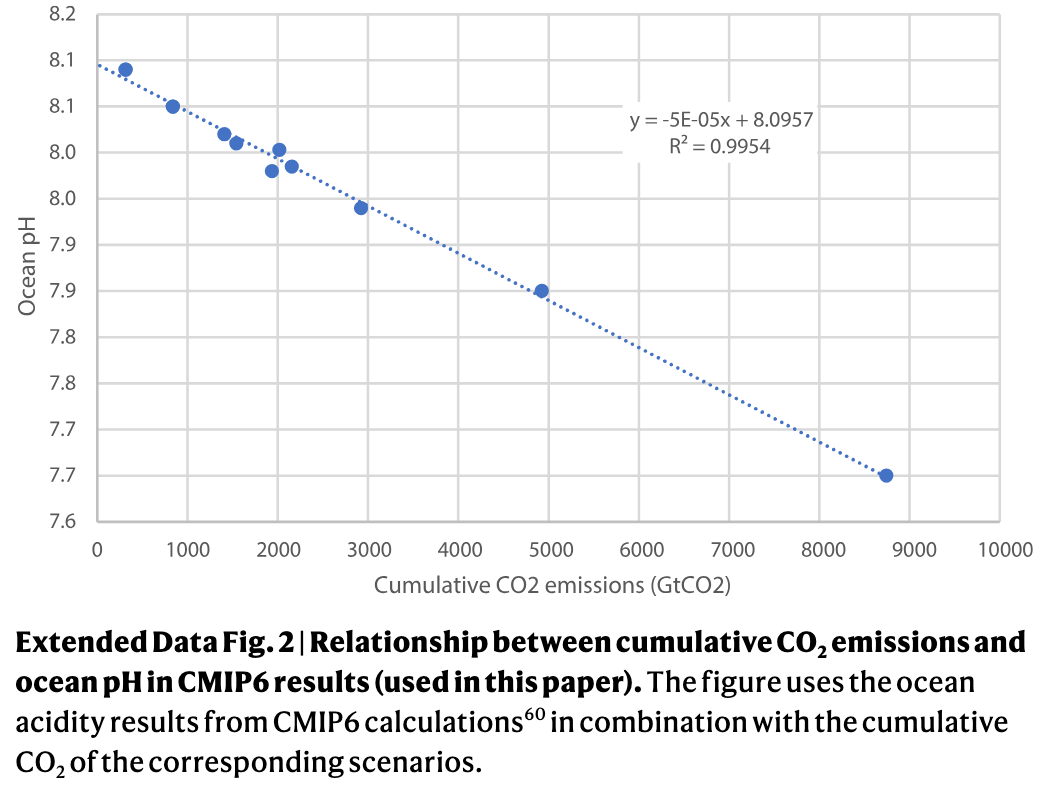

In [125]:
# --- Ocean Acidification → Climate change ---
Δxᴼᵃ⁻ᶜᶜ = 0.8    # Normalised current ocean acidification control variable :contentReference[oaicite:0]{index=0}
Δyᴼᵃ⁻ᶜᶜ = -0.08 # Δy = -4% * y = -4% * 2.0 = -0.08 :contentReference[oaicite:1]{index=1}
sᴼᵃ⁻ᶜᶜ = Δyᴼᵃ⁻ᶜᶜ / Δxᴼᵃ⁻ᶜᶜ
𝐁[ᴼᵃ, ᶜᶜ] = sᴼᵃ⁻ᶜᶜ

# --- Ocean Acidification → Biosphere Integrity (ocean) ---
Δxᴼᵃ⁻ᴮᴵᴼ = 1.0    # OA boundary Δx set to the level causing severe ecosystem degradation :contentReference[oaicite:2]{index=2}
Δyᴼᵃ⁻ᴮᴵᴼ = 1.0    # Severe degradation of marine ecosystems corresponds to Δy = 1 :contentReference[oaicite:3]{index=3}
sᴼᵃ⁻ᴮᴵᴼ = Δyᴼᵃ⁻ᴮᴵᴼ / Δxᴼᵃ⁻ᴮᴵᴼ
𝐁[ᴼᵃ, ᴮᴵᴼ] = sᴼᵃ⁻ᴮᴵᴼ


1.0

## **1.8 Freshwater Use**

In [126]:
# --- Freshwater Use → Biosphere Integrity (freshwater) ---
Δxᶠʷᵘ⁻ᴮᴵᶠ = 1.0   # Freshwater use boundary Δx set to the value that will cause critical degradation of freshwater systems :contentReference[oaicite:0]{index=0} :contentReference[oaicite:0]{index=0}
Δyᶠʷᵘ⁻ᴮᴵᶠ = 1.0   # Δy set to the critical degradation threshold for freshwater biosphere integrity :contentReference[oaicite:1]{index=1} :contentReference[oaicite:1]{index=1}
sᶠʷᵘ⁻ᴮᴵᶠ = Δyᶠʷᵘ⁻ᴮᴵᶠ / Δxᶠʷᵘ⁻ᴮᴵᶠ
𝐁[ᶠʷᵘ, ᴮᴵᶠ] = sᶠʷᵘ⁻ᴮᴵᶠ


1.0

## **1.9 Aerosol Loading**

In [127]:
# --- Aerosol loading → Climate change ---
Δxᵃᵃˡ⁻ᶜᶜ = 1.6    # Current aerosol loading (Δx = 1.6)
Δyᵃᵃˡ⁻ᶜᶜ = -0.9   # Radiative forcing change normalized (Δy = -0.9)
sᵃᵃˡ⁻ᶜᶜ  = Δyᵃᵃˡ⁻ᶜᶜ / Δxᵃᵃˡ⁻ᶜᶜ
𝐁[ᵃᵃˡ, ᶜᶜ] = sᵃᵃˡ⁻ᶜᶜ

# --- Aerosol loading → Freshwater use ---
Δxᵃᵃˡ⁻ᶠʷᵘ = -1.6   # Δx from aerosol‐induced precipitation change (negative sign)
Δyᵃᵃˡ⁻ᶠʷᵘ = 0.0    # No direct freshwater‐use effect (mediated via climate)
sᵃᵃˡ⁻ᶠʷᵘ  = Δyᵃᵃˡ⁻ᶠʷᵘ / Δxᵃᵃˡ⁻ᶠʷᵘ
𝐁[ᵃᵃˡ, ᶠʷᵘ] = sᵃᵃˡ⁻ᶠʷᵘ


-0.0

## **1.10 Strat. Ozone Depletion**

In [128]:
# --- Stratospheric ozone depletion → Climate change ---
Δxˢᵒᵈ⁻ᶜᶜ = 0.44   # Normalised decrease in column ozone (2.2% reduction → Δx = 0.44) :contentReference[oaicite:0]{index=0}
Δyˢᵒᵈ⁻ᶜᶜ = -0.05  # Change in radiative forcing due to ozone depletion (midpoint of –0.05 ± 0.10 W m⁻²) :contentReference[oaicite:1]{index=1}
sˢᵒᵈ⁻ᶜᶜ = Δyˢᵒᵈ⁻ᶜᶜ / Δxˢᵒᵈ⁻ᶜᶜ
𝐁[ˢᵒᵈ, ᶜᶜ] = sˢᵒᵈ⁻ᶜᶜ


-0.11363636363636365

# **2. Human mediated interactions**

- https://www.nature.com/articles/s41558-025-02372-4

# **3. Parallel impacts**

# **4. Conclusion**

In [129]:
@save respath*"data_interaction_param_matrices.jld2" 𝐁 𝐏 𝐑


# **References**

1. Lade, S.J. et al. (2020) ‘Human impacts on planetary boundaries amplified by Earth system interactions’, 3(2), pp. 119–128. Available at: https://doi.org/10.1038/s41893-019-0454-4.
